# Assignment Week 2 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

# Data Preparation

## Data Selection

### Import libraries

In [233]:
# main libraries
import pandas as pd
import numpy as np
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
import imblearn
from numpy import mean, where
from collections import Counter
import qgrid

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Read data

In [36]:
df_1 = pd.read_csv("../fraudTrain.csv")
df_2 = pd.read_csv("../fraudTest.csv")
fraud_df = df_1.append(df_2)

In [37]:
fraud_df.shape
#Craig I noticed that I started out with 23 columns and you started out with 28
#Did you do something to you files before loading them?
#What does everyone else have?

(1852394, 23)

## Data Preprocessing

In [38]:
# Checking for missing values
fraud_df.isnull().any().sum()

0

In [39]:
# Checking for data types
#fraud_df.dtypes

In [40]:
# Checking for unique values
#fraud_df.nunique()

### Formatting and cleansing

In [41]:
#fraud_df = fraud_df.head(10000)

In [42]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]    

In [43]:
#Saving the new data frame since it take a while to create the new ones before after do the above steps and before the columns are dropped. 
fraud_df.to_csv('grp5_fraud_mod.csv')

In [149]:
#Read Modified Fraud File here to skip the feature generation...which can take a while
fraud_df = pd.read_csv("grp5_fraud_mod.csv")

In [150]:
fraud_df.head()

,Unnamed: 0,Unnamed: 0.1,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,merch_long,is_fraud,txn_datetime,age,distance,hour,day,month,year,log_amt
0,0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,...,-82.048315,0,2019-01-01 00:00:18,32,78.773821,0,1,1,2019,1.603420
1,1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,...,-118.186462,0,2019-01-01 00:00:44,42,30.216618,0,1,1,2019,4.674976
2,2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,...,-112.154481,0,2019-01-01 00:00:51,58,108.102912,0,1,1,2019,5.394127
3,3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,...,-112.561071,0,2019-01-01 00:01:16,53,95.685115,0,1,1,2019,3.806662
4,4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,...,-78.632459,0,2019-01-01 00:03:06,34,77.702395,0,1,1,2019,3.736717


In [151]:
# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'Unnamed: 0.1',
    'trans_num',
    'trans_date_trans_time',
    'cc_num',
    'merchant',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'job',
    'dob',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [152]:
qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### Encoding

In [153]:
#create a lis to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender',]
#this is for the linear regression set and does not include amount - if we end up wanting to predict something else
#we would just need replace the log_amt column with something else
num_col = ['age','distance','year','month','day','hour','city_pop']

#this is for the logistic regression model where we are predicitng is_fraud
#num_col = ['log_amt','age','distance','year','month','day','hour','city_pop'] 

fraud_df['Target'] = fraud_df['log_amt'] #can chane if we want something else #for linear regression model
#fraud_df['Target'] = fraud_df['is_fraud'] #for logistic regression model

In [154]:
#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [155]:
fraud_df[cat_col_onehotencode].head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [156]:
fraud_df = fraud_df.drop(['category','gender'],axis=1)

In [157]:
#Count all the columns and put them togeather into one variable for easy tracking
#does not include the log_amt column.
print('Total number of features: {}'.format(len(num_col + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
input_col = (num_col + cat_col_onehotencode)

Total number of features: 21
Numerical Features: 7
Categorical Features: 14


## Data Transformation 

### Standardize the data

In [158]:
fraud_df.head()

,txn_datetime,amt,city_pop,age,distance,hour,day,month,year,log_amt,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2019-01-01 00:00:18,4.97,3495,32,78.773821,0,1,1,2019,1.603420,...,0,0,0,1,0,0,0,0,0,0
1,2019-01-01 00:00:44,107.23,149,42,30.216618,0,1,1,2019,4.674976,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 00:00:51,220.11,4154,58,108.102912,0,1,1,2019,5.394127,...,0,0,0,0,0,0,0,0,0,1
3,2019-01-01 00:01:16,45.00,1939,53,95.685115,0,1,1,2019,3.806662,...,0,0,0,0,0,0,0,0,0,1
4,2019-01-01 00:03:06,41.96,99,34,77.702395,0,1,1,2019,3.736717,...,0,0,0,0,1,0,0,0,0,1


In [159]:
#fraud_df.columns

Index(['txn_datetime', 'amt', 'city_pop', 'age', 'distance', 'hour', 'day',
       'month', 'year', 'log_amt', 'is_fraud', 'Target',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')

In [160]:
features = ['amt', 'city_pop', 'age', 'distance', 'hour', 'day',
       'month', 'year', 'log_amt', 'Target','category_food_dining',
       'category_gas_transport','category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M']
target = ['is_fraud']
# Separating out the features
x = fraud_df.loc[:, features].values
# Separating out the target
y = fraud_df.loc[:,target].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

### Principal Component Analysis

Dimensionality reduction is used in machine learning: to combat computational cost, to control overfitting, and to visualize and help interpret high dimensional data sets.

PCA is a statistical method that creates new features or characteristics of data by analyzing the characteristics of the dataset. Essentially, the characteristics of the data are summarized or combined together. You can also conceive of Principal Component Analysis as "squishing" data down into just a few dimensions from much higher dimensions space.

First, we get the list of features and plot which features have the most explanatory power, or have the most variance. It looks like around 22 or 23 of the features explain the majority of our data.

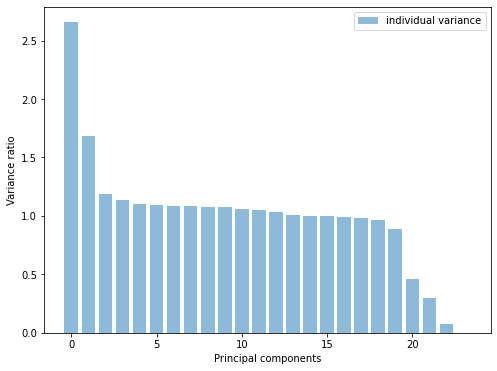

In [170]:
pca = PCA()
pca.fit_transform(x)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(24), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

Then, Let's convert the features into the 2 top features. We'll plot a scatter plot of the data point classification based on these 2 features.

In [171]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
principal_df

,principal component 1,principal component 2
0,-1.473665,-2.553500
1,2.426532,-1.431123
2,2.398425,-0.712493
3,1.246373,-2.267191
4,0.333713,-1.635207
...,...,...
1852389,-0.173077,1.738676
1852390,0.820028,2.450021
1852391,0.495054,2.208575
1852392,-2.259391,0.742238


In [172]:
fraud = pd.DataFrame(data=y, columns = ['is_fraud'])
final_df = pd.concat([principal_df, fraud[['is_fraud']]], axis = 1)
final_df

,principal component 1,principal component 2,is_fraud
0,-1.473665,-2.553500,0
1,2.426532,-1.431123,0
2,2.398425,-0.712493,0
3,1.246373,-2.267191,0
4,0.333713,-1.635207,0
...,...,...,...
1852389,-0.173077,1.738676,0
1852390,0.820028,2.450021,0
1852391,0.495054,2.208575,0
1852392,-2.259391,0.742238,0


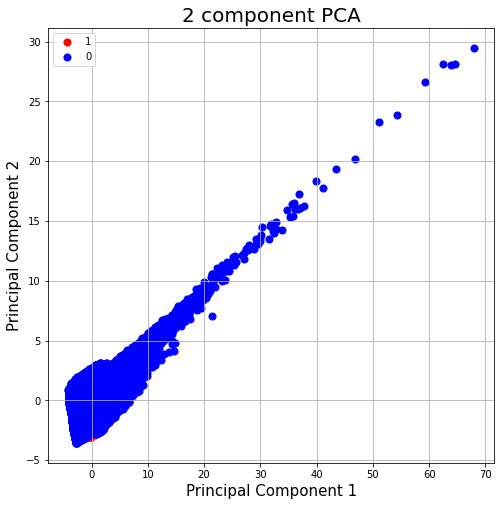

In [173]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['is_fraud'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Data splitting

In [211]:
#build Training/Validation/Test Samples 
def Train_Valid_Test_Split(df,seed,tr):
    #First Shuffle the data
    df = df.sample(n = len(df), random_state=seed)
    df = df.reset_index(drop = True)

    #Splits Training Data = tr% - Validation & Test = (1-tr)/2
    #First take (1-tr) for Validation and Test
    valid_test=df.sample(frac=(1-tr),random_state=seed)

    #Then Split the validation and test data in half 
    valid = valid_test.sample(frac=0.50,random_state=seed)
    test = valid_test.drop(valid.index)

    #The remodeling data is use for training data
    train=df.drop(valid_test.index)
    
    return train, valid, test

#I used a 60% split for trian, 20% for vaild and 20% for Test because that is what the proff recommended. 
train,valid,test = Train_Valid_Test_Split(fraud_df[input_col +['Target']],12,.7)#(dataframe,randomseed,train split)

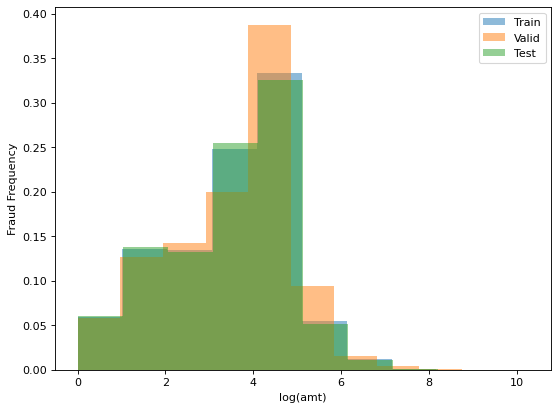

All samples (n = 1,852,394) accounted for.


In [212]:
#check to make sure all samples are accounted for and distribution of continous variable matches across data sets
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(train['Target'], alpha=0.5, label='Train',density=True)
plt.hist(valid['Target'], alpha=0.5, label='Valid',density=True)
plt.hist(test['Target'], alpha=0.5, label='Test',density=True)
plt.legend(loc='upper right')
plt.title = ('log(amt) Distribution in Split Datasets')
plt.xlabel('log(amt)')
plt.ylabel('Fraud Frequency')
plt.show()

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'

In [213]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

#check to make sure all samples are accounted for and prevelence of classification target variable matches across data sets
print('Target checks:')
print('Test prevalence(n = {:0,d}):{:.3f}'.format(len(test),calc_prevalence(test.Target.values)))
print('Valid prevalence(n = {:0,d}):{:.3f}'.format(len(valid),calc_prevalence(valid.Target.values)))
print('Train all prevalence(n = {:0,d}):{:.3f}'.format(len(train),calc_prevalence(train.Target.values)))

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'
print('For continous variables the prevelence is actually the average of the target variable')

Target checks:
Test prevalence(n = 277,859):3.454
Valid prevalence(n = 277,859):3.454
Train all prevalence(n = 1,296,676):3.456
All samples (n = 1,852,394) accounted for.
For continous variables the prevelence is actually the average of the target variable


In [214]:
#change data sets into maxtrix objects for the models
X_train = train[input_col].values
X_valid = valid[input_col].values
X_test = test[input_col].values

y_train = train['Target'].values
y_valid = valid['Target'].values
y_test = test['Target'].values

In [215]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(1296676, 21)
(277859, 21)
(277859, 21)
(1296676,)
(277859,)
(277859,)


### Resampling (SMOTE)

Resampling methods are designed to add or remove examples from the training dataset in order to change the class distribution. Once the class distributions are more balanced, the suite of standard machine learning classification algorithms can be fit successfully on the transformed datasets.

Here, we use oversampling to duplicate or create new synthetic examples in the minority class which is when is_fraud = 1 and use undersampling to delete or merge examples in the majority class which is when is_default = 0. 

SMOTE should only be done in the training data, but test on the original testing data set since the latter reflects the real-world distribution of majority and minority class samples. That's why we apply SMOTE after data splitting.

First, create a synthetic binary classification dataset with 12,000 examples and a 1:100 class distribution. Then we summarize the number of examples in each class to confirm the dataset was created correctly by using Counter(). Next, we oversample the minority class to have 20 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class. Finally, we can create a scatter plot of the dataset and color the examples for each class a different color to clearly see the spatial nature of the class imbalance.

Counter({0: 11880, 1: 120})
Counter({0: 4752, 1: 2376})


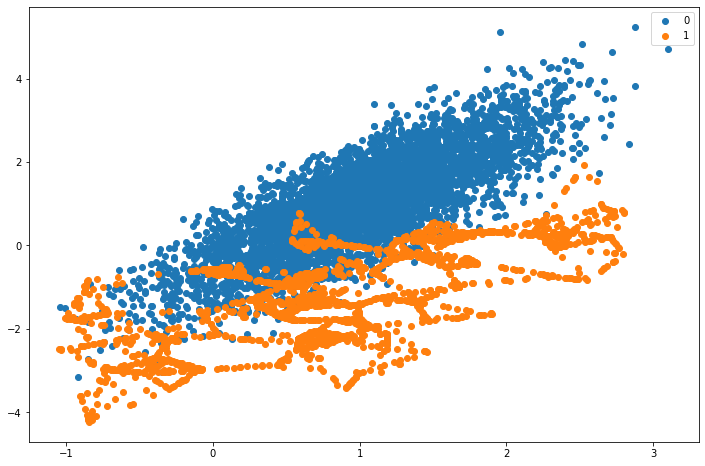

In [218]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
X_train, y_train = make_classification(n_samples=12000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train)
print(counter)


# Scatter plot of examples by class label
plt.figure(figsize=(12, 8))
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))

plt.legend()
plt.show()

In this part, We fit and evaluate a decision tree algorithm that is defined with any required hyperparameters (we will use the defaults), then we will use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.
We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models.

We can test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created.  We grid search a range of values of k from 1 to 10, and evaluate the pipeline for each value.
The mean ROC AUC is reported for each configuration.


In [229]:
# Grid search k value for SMOTE oversampling for imbalanced classification
# Define dataset
x_train, y_train = make_classification(n_samples=12000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
# Define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.2, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
# Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.763
Mean ROC AUC: 0.795
Mean ROC AUC: 0.791
Mean ROC AUC: 0.802
Mean ROC AUC: 0.809
Mean ROC AUC: 0.821
Mean ROC AUC: 0.835
Mean ROC AUC: 0.829
Mean ROC AUC: 0.840
Mean ROC AUC: 0.844


## Correlation Matrix

In [238]:
corrMatrix = fraud_df.corr()
#print (corrMatrix)

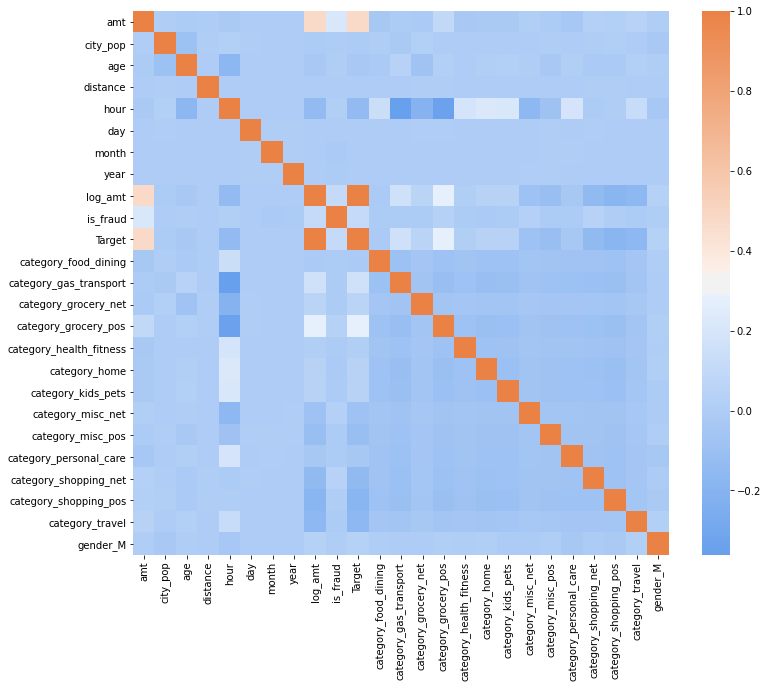

In [248]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(250, 30, s=80, l=65, as_cmap=True)
sns.heatmap(corrMatrix, cmap=cmap)
plt.show()